In [1]:
# Install TensorFlow
!pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc0


2.18.0


In [2]:
# More importing common libraries

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Load the MNIST Data

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1


In [26]:
from PIL import Image
import numpy as np

# Use your image path
image_path = "d:/Deepfake/Code/GAN_Dataset/originals/Image1.jpg"

# Load the image
img = Image.open(image_path).convert('L')  # 'L' for grayscale, remove if you want RGB
img = img.resize((28, 28))  # Resize to MNIST shape if needed

# Convert to numpy array and scale to (-1, +1)
img_array = np.array(img) / 255.0 * 2 - 1

# If you want a batch dimension (like x_train[0:1])
img_array = np.expand_dims(img_array, axis=0)

# If you want to use RGB, use:
# img = Image.open(image_path).convert('RGB')
# img = img.resize((28, 28))
# img_array = np.array(img) / 255.0 * 2 - 1
# img_array = np.expand_dims(img_array, axis=0)

In [27]:
print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


In [29]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

ValueError: not enough values to unpack (expected 3, got 2)

In [30]:
print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


In [31]:
# Dimensionality of the latent space
latent_dim = 100

In [32]:
# Defining the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [33]:
# Defining the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  
  model = Model(i, x)
  return model

In [34]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

In [35]:
generator.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [36]:
discriminator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

z.shape

(None, 100)

In [38]:
# Pass noise through generator to get an image
img = generator(z)

In [39]:
img

<KerasTensor shape=(None, 784), dtype=float32, sparse=False, name=keras_tensor_28>

In [40]:
# Make sure only the generator is trained
discriminator.trainable = False

In [41]:
# The true output is fake, but we label them real!
# Passing the output of Generator to the Discriminator

fake_pred = discriminator(img)

In [42]:
# Create the combined model object
combined_model_gen = Model(z, fake_pred)

In [43]:
# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [49]:
# Config

batch_size = 32
epochs = 30
sample_period = 200 # every `sample_period` steps generate and save some data"

In [50]:

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [51]:
# A function to generate a grid of random samples from the generator and save them to a file

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [53]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
epoch: 1/30, d_loss: 3.06,       d_acc: 0.49, g_loss: 0.02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

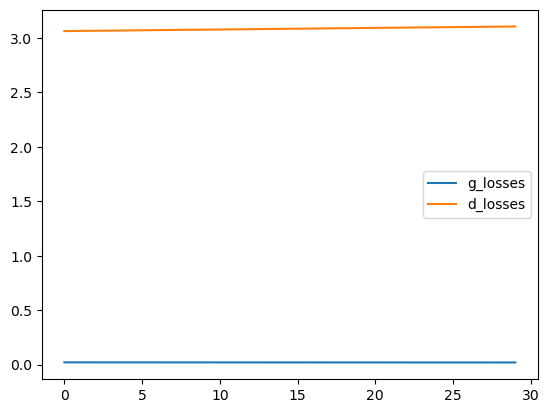

In [86]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [55]:
!ls gan_images

'ls' is not recognized as an internal or external command,
operable program or batch file.


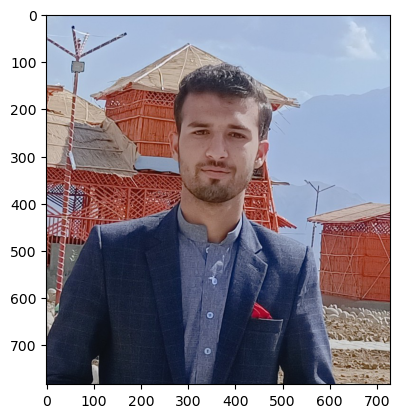

In [84]:
from skimage.io import imread
a = imread('d:/Deepfake/Code/GAN_Dataset/originals/Image2.jpg')
plt.imshow(a)

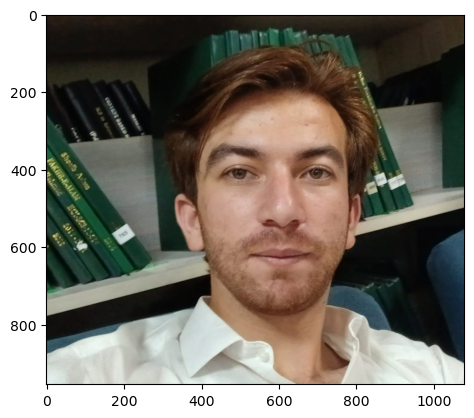

In [85]:
a = imread('d:/Deepfake/Code/GAN_Dataset/originals/Image4.jpg')
plt.imshow(a)

In [ ]:
import os
import numpy as np
from PIL import Image
import random
import cv2

# Paths
image_path = "d:/Deepfake/Code/GAN_Dataset/originals/Image4.jpg"

base_dir = "d:/Deepfake/Code/GAN_Dataset"
splits = ['train', 'val', 'test']
split_ratios = [0.7, 0.15, 0.15]  # Adjust as needed
fake_per_image = 16
img_size = (1080, 1080)  # Change if you want a different size

# Prepare folders
for split in splits:
    for label in ['real', 'fake']:
        os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

# Load and resize real image
img = Image.open(image_path).convert('RGB').resize(img_size)
img_name = os.path.splitext(os.path.basename(image_path))[0]

# Split logic (1 image: put in all splits for demo)
for split in splits:
    # Save real image
    img.save(os.path.join(base_dir, split, 'real', f"{img_name}_real.jpg"))

    # Generate and save fake images
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for i in range(fake_per_image):
        aug_img = img_cv.copy()
        if random.random() > 0.5:
            aug_img = cv2.flip(aug_img, 1)
        # Add subtle Gaussian noise
        noise = np.random.normal(0, 5, aug_img.shape).astype(np.float32)  # Reduced stddev from 25 → 5
        aug_img = aug_img.astype(np.float32) + noise
        aug_img = np.clip(aug_img, 0, 255).astype(np.uint8)
        # Optionally blur
        if random.random() > 0.5:
            aug_img = cv2.GaussianBlur(aug_img, (5, 5), random.uniform(0.5, 1.5))
        # Optionally color shift
        if random.random() > 0.5:
            hsv = cv2.cvtColor(aug_img, cv2.COLOR_BGR2HSV)
            hsv[..., 0] = (hsv[..., 0] + random.randint(-10, 10)) % 180
            aug_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        pil_img = Image.fromarray(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        pil_img = pil_img.resize(img_size)
        pil_img.save(os.path.join(base_dir, split, 'fake', f"{img_name}_fake_{i}.jpg"))

print(" Real and fake images saved in train/val/test with correct labels.") 

✅ Real and fake images saved in train/val/test with correct labels.


In [63]:
for split in splits:
    # Save real image
    img.save(os.path.join(base_dir, split, 'real', f"{img_name}_real.jpg"))

    # Generate and save fake images
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for i in range(fake_per_image):
        aug_img = img_cv.copy()
        if random.random() > 0.5:
            aug_img = cv2.flip(aug_img, 1)
        # Reduce noise std from 25 to 5 for clearer images
        noise = np.random.normal(0, 5, aug_img.shape).astype(np.uint8)
        aug_img = cv2.add(aug_img, noise)
        # Make blur less frequent and lighter
        if random.random() > 0.7:
            aug_img = cv2.GaussianBlur(aug_img, (3, 3), random.uniform(0.2, 0.7))
        # Make color shift less aggressive
        if random.random() > 0.7:
            hsv = cv2.cvtColor(aug_img, cv2.COLOR_BGR2HSV)
            hsv[..., 0] = (hsv[..., 0] + random.randint(-3, 3)) % 180
            aug_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        pil_img = Image.fromarray(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        pil_img = pil_img.resize(img_size)
        pil_img.save(os.path.join(base_dir, split, 'fake', f"{img_name}_fake_{i}.jpg"))